In [1]:
# the aspirational network function and figures

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from pathlib import Path
import seaborn as sns
import pandas as pd
import networkx as nx

from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import auc

In [7]:
# path to the reference network information
REF_NETWORK_PATH = '/Users/finn/desktop/reference_network.npz'
# path for where figures are saved
VIS_PATH = '/Users/finn/images/'

## array manipulation functions

In [2]:
# utils
def remove_diag(data:np.array) -> np.array:
    '''
    zeros out the diagonal (removes metabolite self loops)
    expects a 2D array
    '''
    return data * ~np.eye(len(data), dtype=bool)

def _copy_to_upper(data:np.array) -> np.array:
    '''
    takes a 2D triangular array and copies it to the other half
    (internally used, use copy_to_upper() instead)
    '''
    assert len(data.shape) == 2, 'array must be 2D'
    temp_data = data + data.T
    # correct the diagonal by multilying it by 0.5
    diag_correction = np.ones_like(data) + np.eye(len(data))*-0.5
    return temp_data * diag_correction

def copy_to_upper(data:np.array) -> np.array:
    '''
    copies a triangular array to the other half.
    if the input array is 3D, each array is copied separately.
    '''
    if len(data.shape) == 2:
        return _copy_to_upper(data)
    elif len(data.shape) == 3:
        temp_uppers = np.zeros_like(data)
        for i,k in enumerate(data):
            temp_uppers[i] = _copy_to_upper(k)
        return temp_uppers
    raise NotImplemented('only makes sense for 2D or 3D arrays')



## get best threshold

In [3]:
# removes a lot of safety checks from sklearn implementations.

def np_conf(binarized:np.array,
            ref:np.array) -> tuple[int]:
    '''
    input: binarized is a 1D boolean array (the prediction)
           ref is the 1D boolean array (the ground truth)
    returns confusion matrix bins in the order: tn, fp, fn, tp
    
    NOTE: output order follows sklearn's confustion matrix
    '''
    tp = (binarized * ref).sum()
    fn = (~binarized * ref).sum()
    fp = (binarized * ~ref).sum()
    tn = (~binarized * ~ref).sum()
    return tn, fp, fn, tp

def my_f1(tn:int, fp:int, fn:int, tp:int) -> float:
    ''' calculate f1 score'''
    num = 2 * tp
    denom = (2*tp) + fp + fn
    return num/denom

def get_optimal_value_coarse_np(y_pred:np.array,
                                y_true:np.array,
                                resolution:int = 100):
    ''' calculate an threshold value that optimizes f1 score '''
    # prepare
    y_true = y_true.flatten()
    y_true = y_true.astype(bool)
    y_pred = y_pred.flatten()
    v_min, v_max = y_pred.min(), y_pred.max()

    # loop through threshold ranges
    result = np.zeros((resolution,2))
    for idx, _threshold in enumerate(np.linspace(v_min,v_max,resolution)):
        binarized = (y_pred > _threshold)
        tn, fp, fn, tp = np_conf(binarized, y_true)
        
        f1 = my_f1(tn, fp, fn, tp)
        result[idx] = f1, _threshold

    # returns the single best score and the threshold
    best_f1 = np.argmax(result[:,0])
    return result[best_f1]


## define evaluation metrics


In [4]:
def _best_binarization(assoc_matrix: np.array,
                       ref_adj_matrix: np.array) -> np.array:
    '''
    calculates the best threshold for binarization and applies it
    returns an adjacency matrix
    '''
    # prepare things
    original_shape = assoc_matrix.shape
    ref_adj_matrix = ref_adj_matrix.flatten()
    assoc_matrix = assoc_matrix.flatten()

    # get threshold for binarized results
    _, threshold = get_optimal_value_coarse_np(y_pred = abs(assoc_matrix),
                                               y_true = ref_adj_matrix,
                                               resolution = 100)
    # apply threshold
    rep_binarized = abs(assoc_matrix) > threshold
    rep_binarized = rep_binarized.reshape(original_shape)
    return rep_binarized


In [5]:
def auroc_wrapper(eval_primatives: dict) -> float:
    return auc(eval_primatives['fpr'],
               eval_primatives['tpr'])

def aupr_wrapper(eval_primatives: dict) -> float:
    return auc(eval_primatives['prec'],
               eval_primatives['recall'])

def fdr_wrapper(eval_primatives: dict) -> float:
    tn = eval_primatives['tn']
    fp = eval_primatives['fp']
    fn = eval_primatives['fn']
    tp = eval_primatives['tp']
    if fp+tp == 0:
        return 1
    return fp/(fp+tp)

def mcc_wrapper(eval_primatives: dict) -> float:
    tn = eval_primatives['tn']
    fp = eval_primatives['fp']
    fn = eval_primatives['fn']
    tp = eval_primatives['tp']

    num = (tp * tn) - (fp*fn)
    denom = (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)
    return num / np.sqrt(denom)


In [8]:
# a map between the internal method and a presentable method name
experimental_config = {'n_reps': 100,
                       'signal_bins':50,
                       # pairwise measures utilize pairwise_primatives
                       'pairwise_measures': {'AUROC': auroc_wrapper,
                                             'AUPR': aupr_wrapper,
                                             'FDR': fdr_wrapper,
                                             'MCC': mcc_wrapper},
                       # centrality measures take binarized and reference adjacency arrays
                       'centrality_measures': {'Betweenness': nx.betweenness_centrality,
                                               'Closeness': nx.closeness_centrality,
                                               'Degree': nx.degree_centrality,
                                               'PageRank':nx.pagerank},
                      }


experimental_config['ref_network'] = np.load(REF_NETWORK_PATH)


In [9]:
def get_centrality_vector(bin_assoc_matrix: np.array,
                          cent_method: str,
                          config: dict = experimental_config) -> np.array:
    '''
    from an binarized adjacency matrix (bin_assoc_matrix), calculate the provided centrality method
    returns a 1D array (each entry the centrality score for the corresponding metabolite)
    '''
    if cent_method not in config['centrality_measures'].keys():
        raise Exception(f'centrality method "{cent_method}" is not implemented')
    # make graph from adjacency matrix
    temp_graph = nx.from_numpy_array(bin_assoc_matrix)
    # calculate and extract centrality values
    cent_values = list(config['centrality_measures'][cent_method](temp_graph).values())
    return np.array(cent_values)


In [10]:

# pre-calculate centrality values for the reference network
experimental_config['ref_centralities'] = {}
for k,v in experimental_config['centrality_measures'].items():
    experimental_config['ref_centralities'][k] = get_centrality_vector(experimental_config['ref_network']['adj'], k)


In [11]:
def _eval_primatives(ref_adj_matrix:np.array,
                     assoc_matrix:np.array,
                     config: dict = experimental_config) -> dict[str,float]:
    ''' an internal function
    performs various operations that can be combined for various pairwise eval metrics '''
    # prepare
    ref_adj_matrix = ref_adj_matrix.flatten()
    ref_adj_matrix = ref_adj_matrix.astype(bool)
    assoc_matrix = assoc_matrix.flatten()

    # continuous results
    prec, recall, _ = precision_recall_curve(ref_adj_matrix, assoc_matrix)
    prec.sort() # apparently must be sorted for the "auc" below
    fpr, tpr, _ = roc_curve(ref_adj_matrix, assoc_matrix)

    # binarize the association matrix with f1-optimal threshold
    rep_binarized = _best_binarization(assoc_matrix = assoc_matrix,
                                       ref_adj_matrix = ref_adj_matrix)
    
    # binarized results
    tn, fp, fn, tp = np_conf(ref_adj_matrix, rep_binarized)

    return {'prec': prec,
            'recall': recall, 
            'fpr':fpr,
            'tpr': tpr,
            'tn': tn,
            'fp': fp, 
            'fn': fn,
            'tp': tp}

def calc_pairwise_evals(ref_adj_matrix: np.array,
                        assoc_matrix: np.array,
                        config: dict = experimental_config) -> dict[str,float]:
    '''
    internal function called when loading the dataframe
    ref_adj_matrix is the adjacency matrix of the ground_truth network
    assoc_matrix is the loaded association matrix
    returns a dictionary of eval metrics
    '''
    # generate primative evaluation scores
    primatives_dict = _eval_primatives(ref_adj_matrix=ref_adj_matrix,
                                       assoc_matrix=assoc_matrix)
    # use those evaluation components for pairwise function evaluation
    temp_dict = {}
    for _metric_name, _metric_func in config['pairwise_measures'].items():
        temp_dict[_metric_name] = _metric_func(primatives_dict)
    return temp_dict

In [12]:

def calc_centrality_evals(assoc_matrix: np.array,
                          config: dict = experimental_config) -> dict[str,float]:
    '''
    internal function called when loading the dataframe
    ref_adj_matrix is the adjacency matrix of the ground_truth network
    assoc_matrix is the loaded association matrix
    returns a dictionary of eval metrics
    '''
    
    rep_binarized = _best_binarization(assoc_matrix = copy_to_upper(assoc_matrix),
                                       ref_adj_matrix = config['ref_network']['adj'])
    graph = nx.from_numpy_array(rep_binarized)
    
    temp_dict = {}
    for _metric_name, _metric_func in config['centrality_measures'].items():
        temp_dict[_metric_name] = list(_metric_func(graph).values())
        
    return temp_dict

In [13]:
def build_aspirational_network(signal_factor: float = 0.8,
                               config:dict = experimental_config):
    ''' skip the threshold so we can get auc metrics'''

    noisy = np.random.rand(*config['ref_network']['adj'].shape)
    noisy = (noisy + noisy.T)/2
    noisy_signal = noisy + signal_factor * config['ref_network']['adj']
    return remove_diag(noisy_signal)


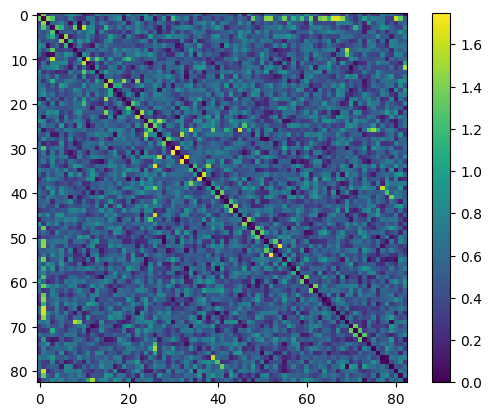

In [14]:
asp_net = build_aspirational_network(signal_factor = 0.8)
plt.imshow(asp_net)
plt.colorbar()

## perform evaluations

In [28]:

def calculate_aspirational_centrality_evaluations(config:dict = experimental_config) -> dict:
    signal_factors = np.linspace(0,1,config['signal_bins'])

    # create dictionary that saves each centrality evaluation
    asp_centralities = dict()
    for _centrality in config['centrality_measures'].keys():
        asp_centralities[_centrality] = np.zeros((config['signal_bins'], config['n_reps']))
    
    for idxs, _s in enumerate(tqdm(signal_factors)):
    
        for _r in range(config['n_reps']):
            test_data = build_aspirational_network(signal_factor=_s)
        
            # get threshold for binarized results
            _, threshold = get_optimal_value_coarse_np(y_pred = abs(test_data),
                                                       y_true = config['ref_network']['adj'], # use F1 score
                                                       resolution = 100)
    
            # apply threshold
            _rep_binarized = abs(test_data) > threshold

            # loop through centrality measures
            for _centrality in config['centrality_measures'].keys():
                # make graph
                temp_graph = nx.from_numpy_array(_rep_binarized)
                temp_centralities = config['centrality_measures'][_centrality](temp_graph)
                # calculate centrality for each node in network
                _raw_centrality = np.array(list(temp_centralities.values()))
                # save residual to dictionary
                asp_centralities[_centrality][idxs, _r] = np.mean((abs(config['ref_centralities'][_centrality]-_raw_centrality)))

    return asp_centralities

asp_data = calculate_aspirational_centrality_evaluations()
asp_data.keys()

100%|███████████████████████████████████████████| 50/50 [00:28<00:00,  1.73it/s]


dict_keys(['Betweenness', 'Closeness', 'Degree', 'PageRank'])

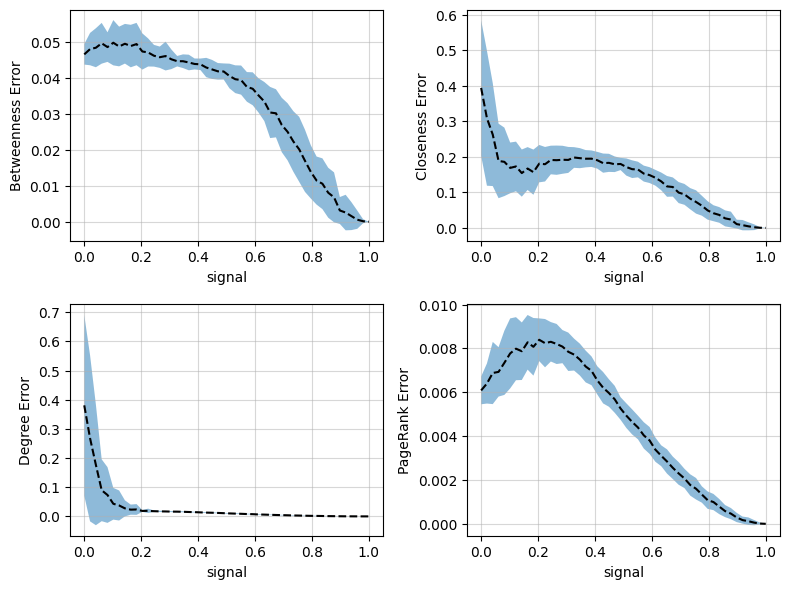

In [31]:



fig,ax = plt.subplots(2,2,figsize=(8,6))
for i, (_cent_title, _cent_values) in enumerate(asp_data.items()):
    
    _means = _cent_values.mean(axis=1)
    _stds = _cent_values.std(axis=1)
    
    ax[i//2][i%2].fill_between(np.linspace(0,1),
                     _means - _stds,
                     _means + _stds,alpha=0.5)
    ax[i//2][i%2].plot(np.linspace(0,1),_means, ls='--',c='k')
    ax[i//2][i%2].grid(alpha=0.5)
    ax[i//2][i%2].set_xlabel('signal')
    ax[i//2][i%2].set_ylabel(f'{_cent_title} Error')
    
plt.tight_layout()

# plt.savefig(f'{VIS_PATH}/aps_network_centralities.png')

## Pairwise Eval Measures

In [33]:
def _eval_primatives(ref_adj_matrix:np.array,
                     assoc_matrix:np.array,
                     config: dict = experimental_config) -> dict[str,float]:
    ''' an internal function
    performs various operations that can be combined for various pairwise eval metrics '''
    # prepare
    ref_adj_matrix = ref_adj_matrix.flatten()
    ref_adj_matrix = ref_adj_matrix.astype(bool)
    assoc_matrix = assoc_matrix.flatten()

    # continuous results
    prec, recall, _ = precision_recall_curve(ref_adj_matrix, assoc_matrix)
    prec.sort() # apparently must be sorted for the "auc" below
    fpr, tpr, _ = roc_curve(ref_adj_matrix, assoc_matrix)

    # binarize the association matrix with f1-optimal threshold
    rep_binarized = _best_binarization(assoc_matrix = assoc_matrix,
                                       ref_adj_matrix = ref_adj_matrix)
    
    # binarized results
    tn, fp, fn, tp = np_conf(ref_adj_matrix, rep_binarized)

    return {'prec': prec,
            'recall': recall, 
            'fpr':fpr,
            'tpr': tpr,
            'tn': tn,
            'fp': fp, 
            'fn': fn,
            'tp': tp}

def calc_pairwise_evals(ref_adj_matrix: np.array,
                        assoc_matrix: np.array,
                        config: dict = experimental_config) -> dict[str,float]:
    '''
    internal function called when loading the dataframe
    ref_adj_matrix is the adjacency matrix of the ground_truth network
    assoc_matrix is the loaded association matrix
    returns a dictionary of eval metrics
    '''
    # generate primative evaluation scores
    primatives_dict = _eval_primatives(ref_adj_matrix=ref_adj_matrix,
                                       assoc_matrix=assoc_matrix)
    # use those evaluation components for pairwise function evaluation
    temp_dict = {}
    for _metric_name, _metric_func in config['pairwise_measures'].items():
        temp_dict[_metric_name] = _metric_func(primatives_dict)
    return temp_dict

{'AUROC': <function __main__.auroc_wrapper(eval_primatives: dict) -> float>,
 'AUPR': <function __main__.aupr_wrapper(eval_primatives: dict) -> float>,
 'FDR': <function __main__.fdr_wrapper(eval_primatives: dict) -> float>,
 'MCC': <function __main__.mcc_wrapper(eval_primatives: dict) -> float>}

In [69]:

def calculate_aspirational_pairwise_evaluations(config:dict = experimental_config) -> dict:
    signal_factors = np.linspace(0,1,config['signal_bins'])

    # create dictionary that saves each evaluation
    asp_pairwise = dict()
    for _pairwise in config['pairwise_measures'].keys():
        asp_pairwise[_pairwise] = np.zeros((config['signal_bins'], config['n_reps']))

    # loop through repetitions and signal factors
    for idxs, _s in enumerate(tqdm(signal_factors)):
    
        for _r in range(config['n_reps']):
            test_data = build_aspirational_network(signal_factor=_s)
        
            # get threshold for binarized results
            _, threshold = get_optimal_value_coarse_np(y_pred = abs(test_data),
                                                       y_true = config['ref_network']['adj'], # use F1 score
                                                       resolution = 100)
    
            # apply threshold
            _rep_binarized = abs(test_data) > threshold

            # calculate evals (all at once, returns a dictionary that needs to be decomposed)
            pairwise_evals = calc_pairwise_evals(ref_adj_matrix = config['ref_network']['adj'],
                                                 assoc_matrix = _rep_binarized,
                                                 config = config)
            # decompose output of eval dictionary into master dictionary
            for (_k, _v) in pairwise_evals.items():
                asp_pairwise[_k][idxs, _r] = _v
            
    return asp_pairwise

asp_pairwise_data = calculate_aspirational_pairwise_evaluations()
asp_pairwise_data.keys()

100%|███████████████████████████████████████████| 50/50 [00:15<00:00,  3.22it/s]


dict_keys(['AUROC', 'AUPR', 'FDR', 'MCC'])

In [73]:
asp_pairwise_data.keys()

dict_keys(['AUROC', 'AUPR', 'FDR', 'MCC'])

In [79]:
# generate a largely repetitive dictionary for using MCC instead

def get_optimal_value_coarse_np_mcc(y_pred, y_true, resolution = 1000):
    # prepare
    y_true = y_true.flatten()
    y_true = y_true.astype(bool)
    y_pred = y_pred.flatten()
    v_min, v_max = y_pred.min(), y_pred.max()

    # loop through threshold ranges
    result = np.zeros((resolution,2))
    for idx, _threshold in enumerate(np.linspace(v_min,v_max,resolution)):
        _binarized = (y_pred > _threshold)
        tn, fp, fn, tp = np_conf(_binarized, y_true)
        #print(idx, ':', tn,fp,fn,tp)
        _val = mcc_wrapper(tn, fp, fn, tp)
        result[idx] = _val, _threshold

    # returns the score and the threshold
    return result[np.argmax(result[:,0])]
    
def calculate_aspirational_pairwise_evaluations_mcc(config:dict = experimental_config) -> dict:
    signal_factors = np.linspace(0,1,config['signal_bins'])

    # create dictionary that saves each evaluation
    asp_pairwise = dict()
    for _pairwise in config['pairwise_measures'].keys():
        asp_pairwise[_pairwise] = np.zeros((config['signal_bins'], config['n_reps']))

    # loop through repetitions and signal factors
    for idxs, _s in enumerate(tqdm(signal_factors)):
    
        for _r in range(config['n_reps']):
            test_data = build_aspirational_network(signal_factor=_s)
        
            # get threshold for binarized results
            _, threshold = get_optimal_value_coarse_np_mcc(y_pred = abs(test_data),
                                                           y_true = config['ref_network']['adj'], # use F1 score
                                                           resolution = 100)
    
            # apply threshold
            _rep_binarized = abs(test_data) > threshold

            # calculate evals (all at once, returns a dictionary that needs to be decomposed)
            pairwise_evals = calc_pairwise_evals(ref_adj_matrix = config['ref_network']['adj'],
                                                 assoc_matrix = _rep_binarized,
                                                 config = config)
            # decompose output of eval dictionary into master dictionary
            for (_k, _v) in pairwise_evals.items():
                asp_pairwise[_k][idxs, _r] = _v
            
    return asp_pairwise

asp_pairwise_data_mcc = calculate_aspirational_pairwise_evaluations_mcc()
asp_pairwise_data_mcc.keys()

100%|███████████████████████████████████████████| 50/50 [00:16<00:00,  3.12it/s]


dict_keys(['AUROC', 'AUPR', 'FDR', 'MCC'])

In [81]:
asp_pairwise_data['FDR']

(50, 100)

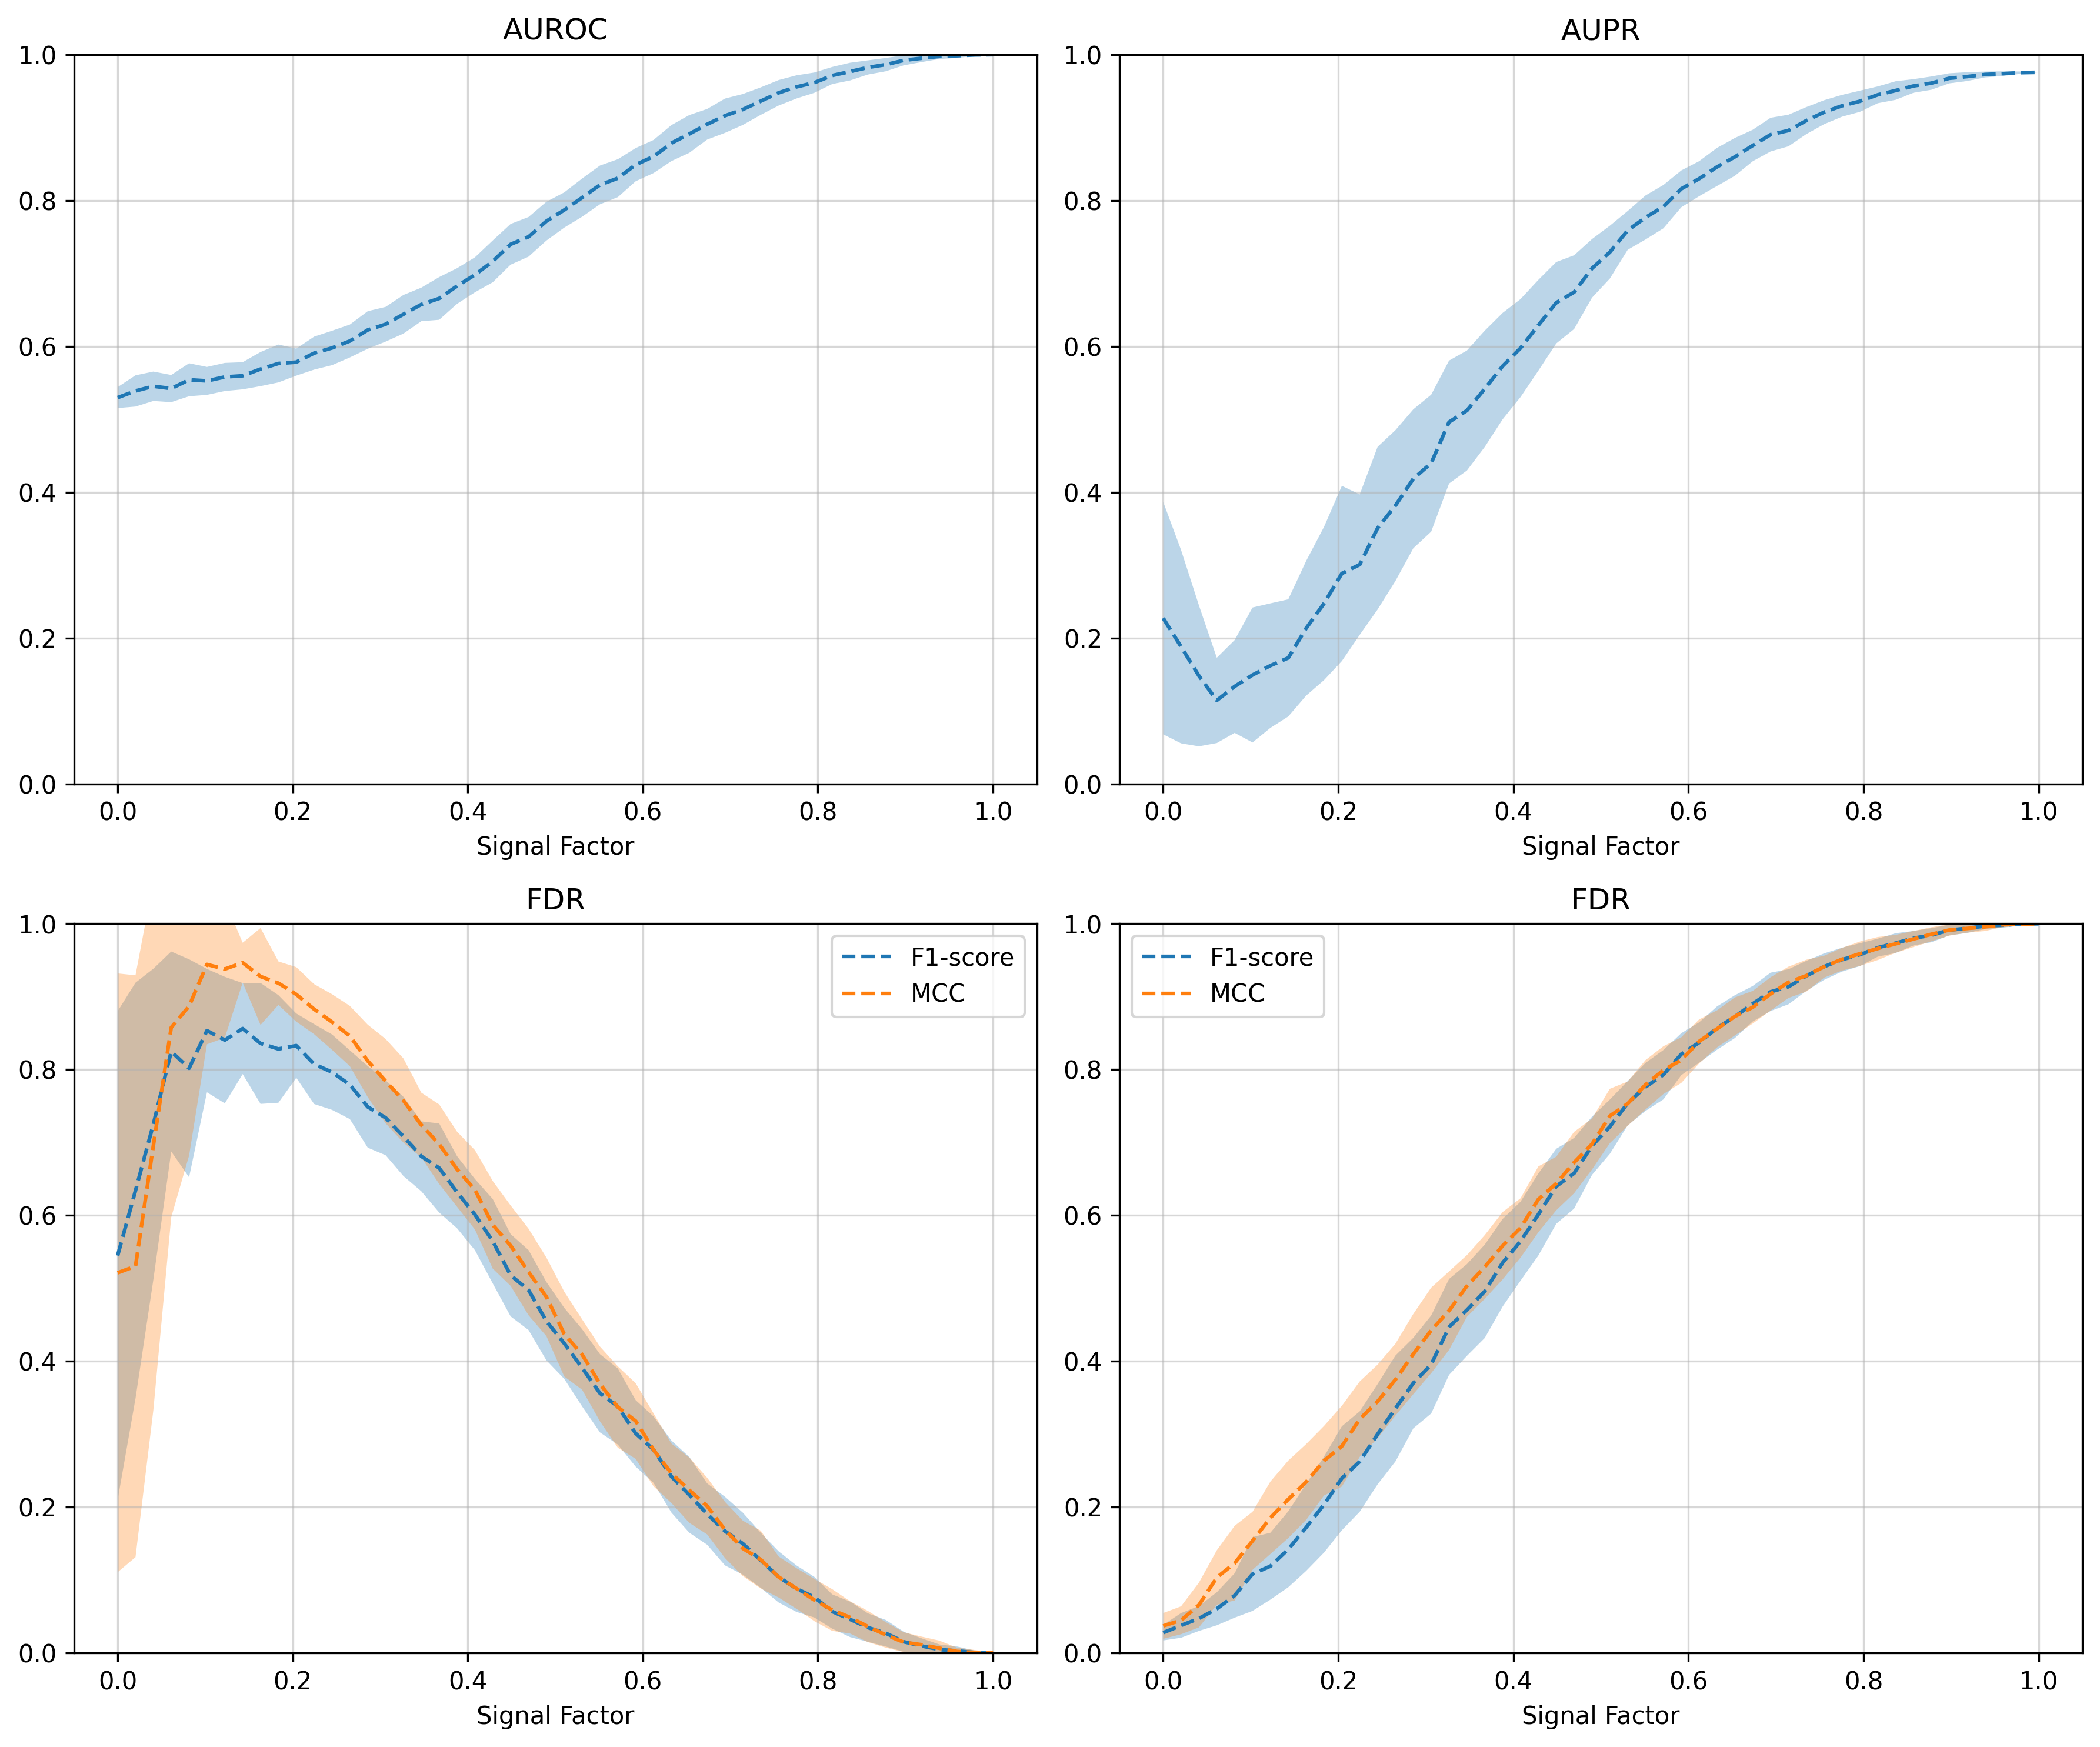

In [104]:
def uncertainty_curve(data_array:np.array, ax: plt.axes, label:str, c:str):
    means = data_array.mean(axis=1)
    stds = data_array.std(axis=1)
    ax.fill_between(np.linspace(0,1,len(means)),
                     means - stds,
                     means + stds, alpha=0.3)
    ax.plot(np.linspace(0,1,len(means)),means, ls='--',c=c,label=label)
    
fig,ax = plt.subplots(2,2,figsize=(12,10),dpi=300)

# AUROC
ax[0][0].set_title('AUROC')
uncertainty_curve(asp_pairwise_data['AUROC'], ax = ax[0][0], label='F1-score',c='tab:blue')

# AUPR
ax[0][1].set_title('AUPR')
uncertainty_curve(asp_pairwise_data['AUPR'], ax = ax[0][1], label='F1-score',c='tab:blue')

# FDR
ax[1][0].set_title('FDR')
uncertainty_curve(asp_pairwise_data['FDR'], ax = ax[1][0], label='F1-score',c='tab:blue')
uncertainty_curve(asp_pairwise_data_mcc['FDR'], ax = ax[1][0], label='MCC',c='tab:orange')
ax[1][0].legend()

# MCC
ax[1][1].set_title('FDR')
uncertainty_curve(asp_pairwise_data['MCC'], ax = ax[1][1], label='F1-score',c='tab:blue')
uncertainty_curve(asp_pairwise_data_mcc['MCC'], ax = ax[1][1], label='MCC',c='tab:orange')
ax[1][1].legend()

for i in range(4):
    ax[i//2][i%2].set_xlabel('Signal Factor')
    ax[i//2][i%2].grid(alpha=0.5)
    ax[i//2][i%2].set_ylim(0,1)

plt.tight_layout()

# plt.savefig(f'{VIS_PATH}/aps_network_pairwise_new.png')